In [1]:
import math
import numpy as np
import random
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d1 - d1)/h)

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

d1 4.0
d2 3.9999699999999994
slope 0.0


In [16]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            print(f"backward for {v.data} {v.grad}")
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self,))
        return out
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

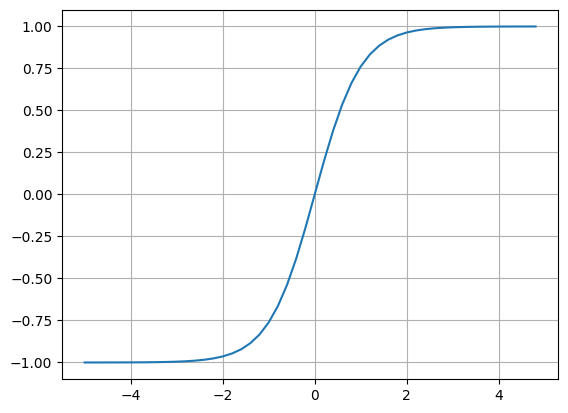

In [4]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [43]:

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [24]:
n = MLP(3, [4,4,1])


In [25]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] # inputs

ys = [1.0, -1.0, -1.0, 1.0] # goals

ypred = [n(x) for x in xs]

ypred    

[Value(data=0.16220132720753136, grad=0),
 Value(data=-0.40489600698924405, grad=0),
 Value(data=0.3152777076128212, grad=0),
 Value(data=-0.2489010002862869, grad=0)]

backward for 4.345764535289494 1
backward for 1.5597537085160877 1
backward for -1.2489010002862868 -2.4978020005725736
backward for -0.2489010002862869 -9.991208002290294
backward for -0.25424088843664466 0
backward for -0.3040694632921586 0
backward for -0.8728297626921334 0.0
backward for -1.3448395840170155 0
backward for -0.8334764986190195 0
backward for -0.3909716814816726 0
backward for -0.30337870560916824 0
backward for -0.30337870560916824 0
backward for -0.08759297587250438 0
backward for -0.44250481713734685 0
backward for -0.5113630853979959 0
backward for 0.049828574855513966 0
backward for 0.06554479910311674 0
backward for 0.01144936326431845 0
backward for 0.01144936326431845 0
backward for -0.12603728796349142 0.0
backward for -0.12671110620010462 0
backward for -0.11578461854206368 0
backward for 0.1559865939139401 0
backward for 0.10130115966308002 0
backward for 0.05468543425086006 0
backward for 0.05468543425086006 0
backward for -0.2717712124560038 0
backward fo

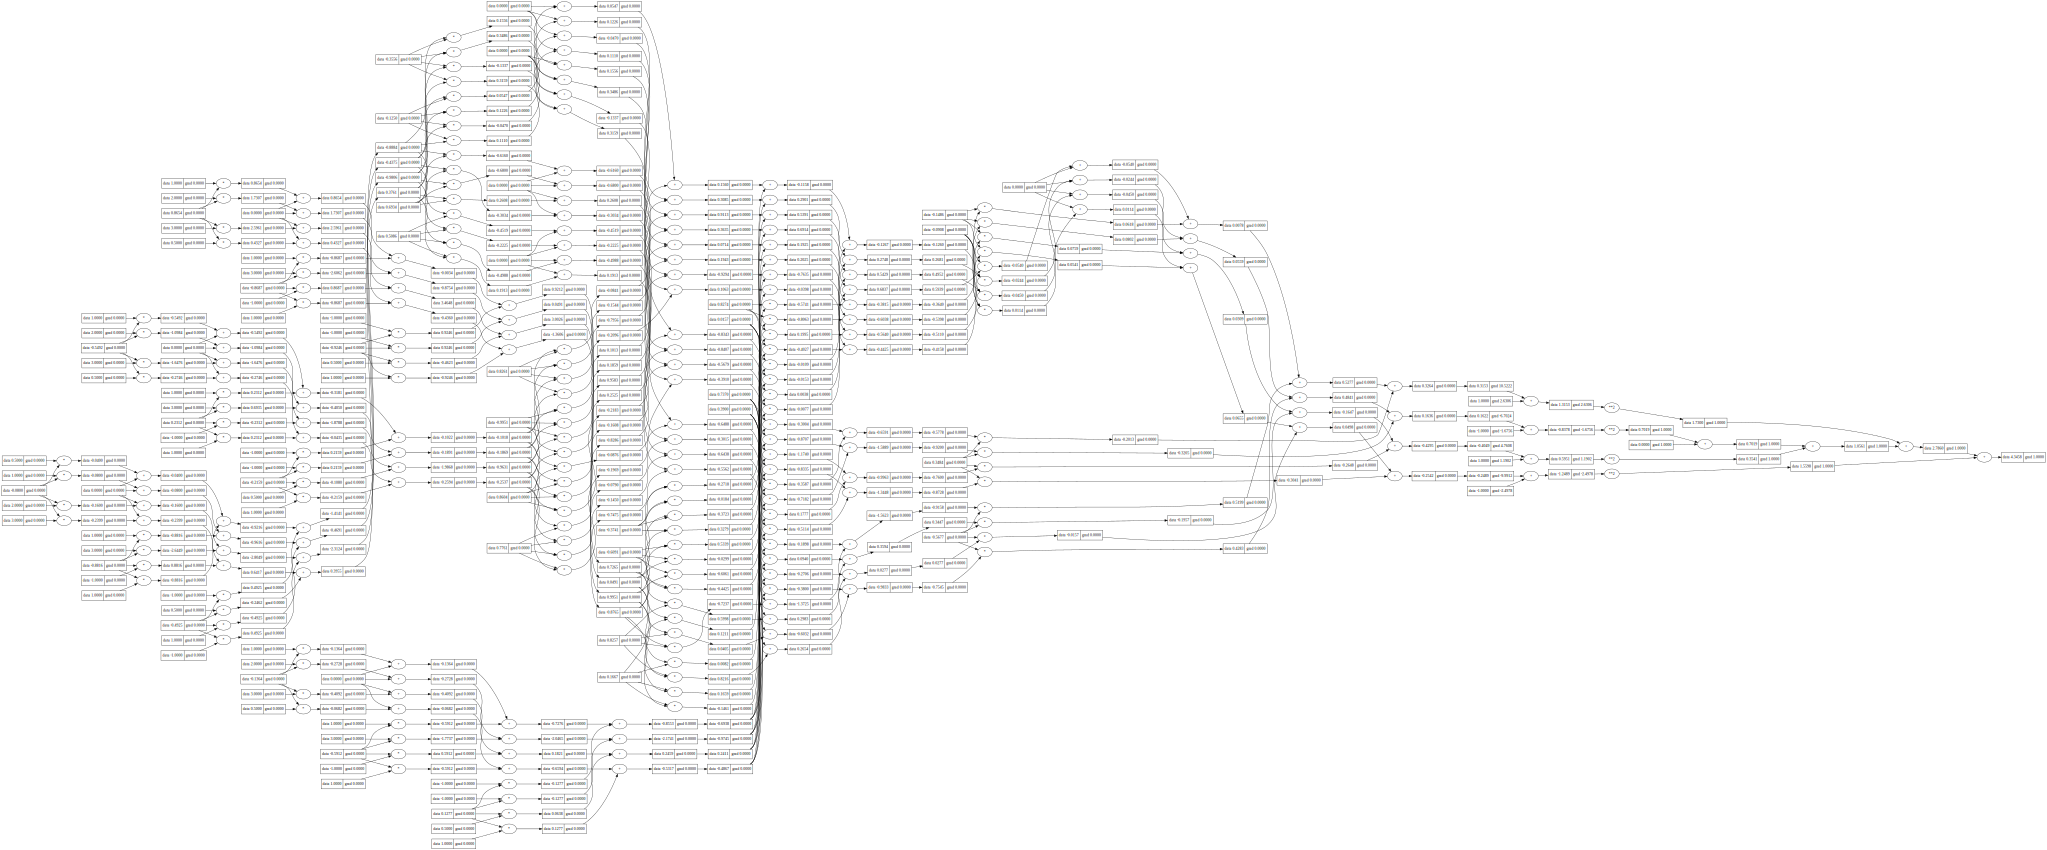

In [ ]:

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

loss.backward()

for node in n.parameters(): 
    node.data += -0.001 * node.grad    
    print(f"param: {node.data} {node.grad}")
    
print(f"Learning rate: {loss}")

draw_dot(loss)


backward for 0 1
backward for -0.6897638751078645 0
backward for 0.2709887154412616 0
backward for -1 0.0
backward for -0.2709887154412616 0
backward for -0.9607525905491261 0
backward for -0.9607525905491261 0
backward for 1 0.0
backward for -0.9607525905491261 0
backward for 0 0


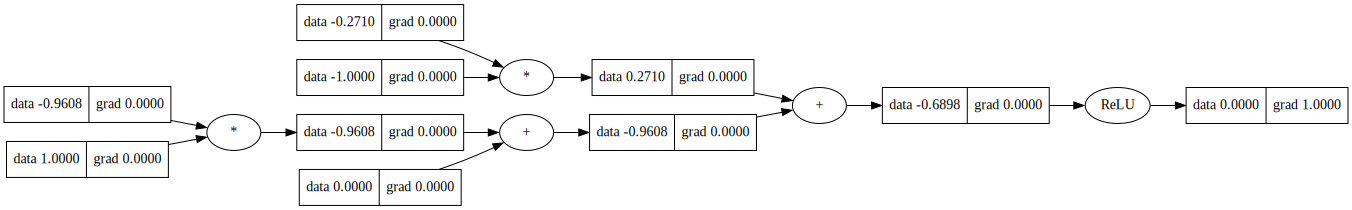

In [44]:
n1 = Layer(2,1)
n2 = n1([1,-1])
n2.backward()
draw_dot(n2)